## cloudFPGA TRIERES Lab
### Case study: Monte-carlo European Pricing Engine 
### You don't need FPGA knowledge, just basic Python syntax !!!

![Trieres Logo](./etc/trieres.png)

Assuming that the FPGA is already flashed

Configure the Python path to look for FPGA aceleration library

In [21]:
import time
import sys
import os
import numpy as np
import matplotlib.pyplot as plt
import QuantLib as ql

In [22]:
trieres_lib=os.environ['cFpRootDir'] + "HOST/quantitative_finance/mceuropeanengine/languages/python/build"
sys.path.append(trieres_lib)

Import the FPGA accelerator library

In [23]:
import _trieres

In [24]:
loop_nm = 2;    
seed = 4332;
underlying = 36;
volatility = 0.20;
dividendYield = 0.0;
riskFreeRate = 0.06;
timeLength = 1;
strike = 40;
optionType = 1;
requiredTolerance = 0.02;
requiredSamples = 1;
timeSteps = 1;
maxSamples = 1; 

Assign the IP of the FPGA that is already loaded with MCEuropeanEngine image

In [25]:
#fpga_ip=os.environ['FPGA_IP']
fpga_ip="10.12.200.92"
print(fpga_ip)

10.12.200.92


Execute the FPGA accelerator as a Python function

In [26]:
start_fpga = time.time()

price_vector = _trieres.mceuropeanengine(loop_nm, fpga_ip, "2718",
                            seed,
                            underlying,
                            volatility,
                            dividendYield,
                            riskFreeRate,
                            timeLength,
                            strike,
                            optionType,
                            requiredTolerance,
                            requiredSamples,
                            timeSteps,
                            maxSamples);
done_fpga = time.time()
elapsed_fpga = done_fpga - start_fpga

In [27]:
print("Output pricing vector from FPGA:")
print(price_vector)

Output pricing vector from FPGA:
[4413.28 4414.28]


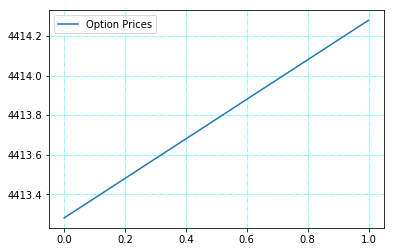

In [28]:
line1, = plt.plot(price_vector, label='Option Prices')
plt.legend(handles=[line1], loc='best')
plt.grid(b=True, color='aqua', alpha=0.6, linestyle='dashdot')
plt.show()

In [56]:
start_cpu = time.time()

option = ql.EuropeanOption(ql.PlainVanillaPayoff(ql.Option.Call, 100.0),
                                   ql.EuropeanExercise(ql.Date(7, ql.June, 2014)))

riskFreeTS = ql.YieldTermStructureHandle(ql.FlatForward(today, 0.05, ql.Actual365Fixed()))
dividendTS = ql.YieldTermStructureHandle(ql.FlatForward(today, 0.01, ql.Actual365Fixed()))
volatility = ql.BlackVolTermStructureHandle(ql.BlackConstantVol(today, ql.NullCalendar(), 0.1, ql.Actual365Fixed()))
initialValue = ql.QuoteHandle(ql.SimpleQuote(100))
process = ql.BlackScholesMertonProcess(initialValue, dividendTS, riskFreeTS, volatility)

steps = 2
rng = "pseudorandom" # could use "lowdiscrepancy"
numPaths = 100000

MCengine = ql.MCEuropeanEngine(process, rng, steps, requiredSamples=numPaths)
option.setPricingEngine(engine)
%time print(option.NPV())
done_cpu = time.time()
elapsed_cpu = done_cpu - start_cpu

0.0
CPU times: user 95 µs, sys: 41 µs, total: 136 µs
Wall time: 140 µs


In [57]:
print("FPGA time = "+'{0:.10f}'.format(elapsed_fpga)+"\nCPU time  = "+'{0:.10f}'.format(elapsed_cpu))

FPGA time = 0.0088100433
CPU time  = 0.0015792847


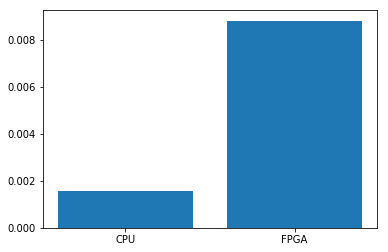

In [58]:
height = [elapsed_cpu, elapsed_fpga]
bars = ('CPU', 'FPGA')
y_pos = np.arange(len(bars))
plt.bar(y_pos, height)
plt.xticks(y_pos, bars)
plt.show()